In [14]:
import cv2 as cv
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

%config IPCompleter.greedy=True

In [16]:
#read scanned data from text file

df = pd.read_csv('capture1.csv',delimiter=',')
x = df.values[:,0]
y = df.values[:,1]
#print(x,y)

df = pd.read_csv('capture1.csv',delimiter=',')
angle = df.values[:,0]
#print(angle)
distance = df.values[:,1]



In [17]:
#polar to cartesian converison
cartesian = [(r*math.cos(phi*math.pi/180), r*math.sin(phi*math.pi/180)) for r, phi in zip(distance, angle)]


In [18]:
#shift to all positive value
x, y = map(list, zip(*cartesian))
x=  np.array(x)
y=  np.array(y)

x+=  x.min()*-1
y+=  y.min()*-1

print(y.min())

data = np.vstack([y, x])


0.0


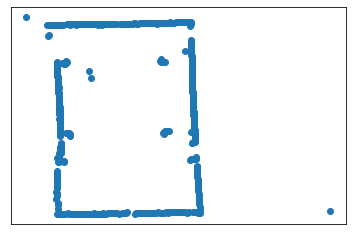

In [19]:
###only for matplotLib

#plt.scatter(y,x, color='yellowgreen', marker='.',label='Inliers')
plt.scatter(y,x)

###remove the axis tag from here
plt.xticks([])
plt.yticks([])


#plt.scatter(y,x)
plt.savefig('floor.png')
plt.show()

In [21]:
### canny edge detection

image = cv.imread('floor.png')
original = image.copy()
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
'''
cv.imshow("gray",gray)
cv.waitKey(1000)
cv.destroyAllWindows()
'''
canny = cv.Canny(gray,100,200)


## creating mask to hide axis

'''
Here's a simple approach:

Convert image to grayscale
Color threshold to isolate green
Find contours and fill in mask
Bitwise-and to get result
https://stackoverflow.com/questions/57940737/how-to-mask-everything-in-an-image-except-for-a-specific-color-inside
'''

lower = np.array([35, 0, 0], dtype="uint8")
upper = np.array([131, 255, 185], dtype="uint8")
mask = cv.inRange(image, lower, upper)

cnts = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cv.fillPoly(mask, cnts, (255,255,255))
result = cv.bitwise_and(original,original,mask=mask)


cv.imshow("result",result)
cv.waitKey(10000)
cv.destroyAllWindows()
###Hough transform

#gray = cv.cvtColor(result,cv.COLOR_BGR2GRAY)
#print(gray)
edges = cv.Canny(gray,50,150,apertureSize = 3)
minLineLength = 100
maxLineGap = 10
lines = cv.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)

for x1,y1,x2,y2 in lines[0]:
    cv.line(image,(x1,y1),(x2,y2),(0,255,0),2)
#cv.imwrite('houghlines5.jpg',image)


cv.imshow("canny",image)
cv.waitKey(10000)
cv.destroyAllWindows()

In [22]:
###### coverting this into 2d array

#x=x.reshape( 1,-1)

#print(x)
#y=y.reshape(1,-1)
print(x.min, x.max)

# generate coordinates of line
#x = np.arange(-200, 200)

#y = 0.2 * x + 20
data = np.vstack([x, y])
print(data.shape)
print(data)
img = np.zeros([100,100,3],dtype=np.uint8)
cv.imshow("data",data)
cv.waitKey(1000)
cv.destroyAllWindows()

<built-in method min of numpy.ndarray object at 0x0000025F02B7F6C0> <built-in method max of numpy.ndarray object at 0x0000025F02B7F6C0>
(2, 578)
[[13338.4869863  13352.59933404 13355.11943502 ... 13368.99510942
  13355.08926901 13341.58158014]
 [ 4210.11908019  4267.68497587  4325.20778625 ...  3921.44737629
   3979.5308153   4037.28251182]]


In [29]:
import cv2
import numpy as np

image = cv2.imread('floor.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)

minLineLength = 750
maxLineGap = 0
lines = cv2.HoughLinesP(close,1,np.pi/180,100,minLineLength,maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(image,(x1,y1),(x2,y2),(36,255,12),3)

cv2.imshow('thresh', thresh)
cv2.imshow('close', close)
cv2.imshow('image', image)
cv2.waitKey(1000)
cv2.destroyAllWindows()

In [2]:
#Import packages
import os
import cv2
import numpy as np
#import tensorflow as tf
import sys

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Import utilites
#from utils import label_map_util
#from utils import visualization_utils as vis_util

# Name of the directory containing the object detection module we're using
#MODEL_NAME = 'inference_graph'
IMAGE_NAME = 'floor.png'
#Remove Small Items
im_gray = cv2.imread(IMAGE_NAME, cv2.IMREAD_GRAYSCALE)
(thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
thresh = 127
im_bw = cv2.threshold(im_gray, thresh, 255, cv2.THRESH_BINARY)[1]
#find all your connected components 
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(im_bw, connectivity=8)
#connectedComponentswithStats yields every seperated component with information on each of them, such as size
#the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
sizes = stats[1:, -1]; nb_components = nb_components - 1

# minimum size of particles we want to keep (number of pixels)
#here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
min_size = 150  

#your answer image
img2 = np.zeros((output.shape))
#for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img2[output == i + 1] = 255

cv2.imshow('room detector', img2)
#MorphologicalTransform
kernel = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(img2, kernel)
erosion = cv2.erode(img2, kernel, iterations=6)

#cv2.imshow("img2", img2)
cv2.imshow("Dilation", dilation)
#cv2.imwrite("Dilation.jpg", dilation)
#cv2.imshow("Erosion", erosion)
image = dilation
#image = cv2.imread('floortest2.PNG')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
#close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)

minLineLength = 550
maxLineGap = 60
lines = cv2.HoughLinesP(close,1,np.pi/180,100,minLineLength,maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(image,(x1,y1),(x2,y2),(36,255,12),3)

cv2.imshow('thresh', thresh)
cv2.imshow('close', close)
cv2.imshow('image', image)
cv2.waitKey(10000)
cv2.destroyAllWindows()
# Press any key to close the image
cv2.waitKey(0)

# Clean up
cv2.destroyAllWindows()

AttributeError: 'NoneType' object has no attribute 'shape'

In [34]:
model = LineModelND()
model.estimate(data)
x1= np.arange(100,100)

fig,ax = plt.subplots()

print(model.params)
ax.plot(data[:,0], data[:,1], '.r')
ax.plot(x1, model.predict_y(x1))


NameError: name 'LineModelND' is not defined

In [ ]:


ax.plot(x1, model.predict_y(x1), '-b')
mode_robust, inliers = ransac (data, LineModelND, min_samples= 2, 
                               residual_threshold=2,
                               
                               
                               max_trials=1500)

outliers= (inliers== False)
print(data)
print(data[inliers])
x= mode_robust.predict_y(x1)
ax.plot(x1, x, '-y')


In [ ]:
from PIL import Image
import numpy as np

w, h = 512, 512
data = np.zeros((h, w, 3), dtype=np.uint8)
data[0:256, 0:256] = [255, 0, 0] # red patch in upper left
img = Image.fromarray(data, 'RGB')
img.save('my.png')
img.show()